In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rebound
from astropy import constants as const
from astropy import units as u
from joblib import Parallel, delayed
from scipy import ndimage
from tqdm import tqdm

In [2]:
import numpy as np
from astropy import constants as const
from astropy import units as u

# FIXME
PERIOD_U = 2.0 * (0.12771 * u.day)
PERIOD = PERIOD_U.to_value(u.s)

MASS_WD_U = 1.0 * u.M_sun
MASS_WD = MASS_WD_U.to_value(u.g)


# http://www.sciencebits.com/StellarEquipartition
BETA_WD = 0.5
RADIUS_WD_U = 2e4 * u.km * (BETA_WD / 0.5) / np.cbrt(MASS_WD_U / (1 * u.M_sun))
RADIUS_WD = RADIUS_WD_U.to_value(u.cm)

MASS_COMPANION_U = 0.5 * u.M_sun
MASS_COMPANION = MASS_COMPANION_U.to_value(u.g)

SEPARATION_U = np.cbrt(const.G * (MASS_WD_U + MASS_COMPANION_U) * PERIOD_U**2 / (4*np.pi**2))
SEPARATION = SEPARATION_U.to_value(u.cm)

_q = MASS_COMPANION / MASS_WD
RADIUS_ROCHE_LOBE_COMPANION_U = 0.49 * _q**(2.0/3.0) / (0.6*_q**(2.0/3.0) + np.log(1.0 + _q**(1.0/3.0))) * SEPARATION_U
RADIUS_ROCHE_LOBE_COMPANION = RADIUS_ROCHE_LOBE_COMPANION_U.to_value(u.cm)

# RADIUS_COMPANION_U = 1.0 * u.R_sun * (MASS_COMPANION_U / (1.0 * u.M_sun)).to(u.dimensionless_unscaled)**0.8
RADIUS_COMPANION_U = RADIUS_ROCHE_LOBE_COMPANION_U
RADIUS_COMPANION = RADIUS_COMPANION_U.to_value(u.cm)

ORBIT_RADIUS_WD_U = SEPARATION_U * MASS_COMPANION_U / (MASS_WD_U + MASS_COMPANION_U)
ORBIT_RADIUS_WD = ORBIT_RADIUS_WD_U.to_value(u.cm)

VELOCITY_WD_U = np.sqrt(const.G * MASS_COMPANION_U**2 / (MASS_COMPANION_U + MASS_WD_U) / SEPARATION_U)
VELOCITY_WD = VELOCITY_WD_U.to_value(u.cm/u.s)

VELOCITY_COMPANION_U = VELOCITY_WD_U * MASS_WD_U / MASS_COMPANION_U
VELOCITY_COMPANION = VELOCITY_COMPANION_U.to_value(u.cm/u.s)

PARTICLE_VELOCITY_INF_U = 1_000 * u.km / u.s
PARTICLE_VELOCITY_INF = PARTICLE_VELOCITY_INF_U.to_value(u.cm/u.s)
PARTICLE_VELOCITY_U = np.sqrt(2 * const.G * MASS_WD_U / RADIUS_WD_U + PARTICLE_VELOCITY_INF_U**2)
# PARTICLE_VELOCITY_U = 5_000 * u.km / u.s
PARTICLE_VELOCITY = PARTICLE_VELOCITY_U.to_value(u.cm/u.s)

INCLINATION = np.deg2rad(60.0)
PHASES = np.deg2rad(np.linspace(0, 360, 33))

In [3]:
FAST = False

In [4]:
N_PARTICLES = 100_000
if FAST:
    N_PARTICLES = 1_000

N_BATCH_PARTCILES = 500

assert N_PARTICLES % N_BATCH_PARTCILES == 0
    
INT_STEP_U = 100 * u.s
INT_STEP = INT_STEP_U.to_value(u.s)

TOTAL_TIME_U = 20 * PERIOD_U
TOTAL_TIME = TOTAL_TIME_U.to_value(u.s)

N_INT = int(np.round(TOTAL_TIME / INT_STEP))

PROJECTION_PIXELS = 256
PROJECTION_SIZE_U = 1e13 * u.cm
PROJECTION_SIZE = PROJECTION_SIZE_U.to_value(u.cm)

PROJECTION_ZOOM_FACTOR = 8

N_PARTICLES * N_INT * 8 * 10 / (1 << 30)

32.88686275482178

In [5]:
%%time

def simulation(n_particles, *, rng, progress_bar=False):
    sim = rebound.Simulation()

    sim.G = const.G.cgs.value

    # Add WD
    sim.add(
        m=MASS_WD,
        r=RADIUS_WD,
        x=-SEPARATION * MASS_COMPANION / (MASS_WD + MASS_COMPANION),
        y=0,
        z=0,
        vx=0,
        vy=VELOCITY_WD,
        vz=0,
        hash='wd',
    )

    # Add companion
    sim.add(
        m=MASS_COMPANION,
        r=RADIUS_COMPANION,
        x=SEPARATION * MASS_WD / (MASS_WD + MASS_COMPANION),
        y=0,
        z=0,
        vx=0,
        vy=-VELOCITY_COMPANION,
        vz=0,
        hash='companion',
    )

    # Add particles
    rng = np.random.default_rng(rng)
    for i in range(n_particles):
        phi = rng.uniform(0, 2*np.pi)
        theta = np.arcsin(rng.uniform(-1, 1))
        dx = 1.01 * RADIUS_WD * np.cos(phi) * np.cos(theta)
        dy = 1.01 * RADIUS_WD * np.sin(phi) * np.cos(theta)
        dz = 1.01 * RADIUS_WD * np.sin(theta)
        dv_x = PARTICLE_VELOCITY * np.cos(phi) * np.cos(theta)
        dv_y = PARTICLE_VELOCITY * np.sin(phi) * np.cos(theta)
        dv_z = PARTICLE_VELOCITY * np.sin(theta)
        sim.add(
            r=1.0,  # some small number for collisions
            x=sim.particles['wd'].x + dx,
            y=sim.particles['wd'].y + dy,
            z=sim.particles['wd'].z + dz,
            vx=sim.particles['wd'].vx + dv_x,
            vy=sim.particles['wd'].vy + dv_y,
            vz=sim.particles['wd'].vz + dv_z,
            hash=f'p{i}',
        )

    sim.integrator = 'whfast'
    sim.collision = 'linetree'
    if FAST:
        sim.collision = 'none'
    sim.collision_resolve = 'merge'
    sim.N_active = 2
    sim.dt = INT_STEP

    wd_coord = np.zeros((N_INT, 3))
    wd_velocity = np.zeros((N_INT, 3))
    companion_coord = np.zeros((N_INT, 3))
    particles_coord = np.zeros((n_particles, N_INT, 3))
    
    it = range(N_INT)
    if progress_bar:
        it = tqdm(it)
    for i in it:
        sim.step()
        wd_coord[i] = sim.particles['wd'].xyz
        wd_velocity[i] = sim.particles['wd'].vxyz
        companion_coord[i] = sim.particles['companion'].xyz
        for j in range(n_particles):
            particles_coord[j, i] = sim.particles[f'p{j}'].xyz
    
    return wd_coord, companion_coord, particles_coord

# wd_coord, companion_coord, particles_coord = simulation(N_PARTICLES, progress_bar=True)
result = Parallel(n_jobs=-1)(
    delayed(simulation)(N_BATCH_PARTCILES, rng=i, progress_bar=False)
    for i in tqdm(range(0, N_PARTICLES, N_BATCH_PARTCILES))
)
wd_coord_, companion_coord_, particles_coord_ = zip(*result)
np.testing.assert_array_equal(wd_coord_[0], wd_coord_[1])
wd_coord = wd_coord_[0]; del wd_coord_
companion_coord = companion_coord_[0]; del companion_coord_
particles_coord = np.concatenate(particles_coord_); del particles_coord_

100%|██████████| 200/200 [00:01<00:00, 128.92it/s]


CPU times: user 6.63 s, sys: 8.57 s, total: 15.2 s
Wall time: 3min 29s


In [6]:
particles_coord.shape

(100000, 4414, 3)

(-80000000000.0, 80000000000.0)

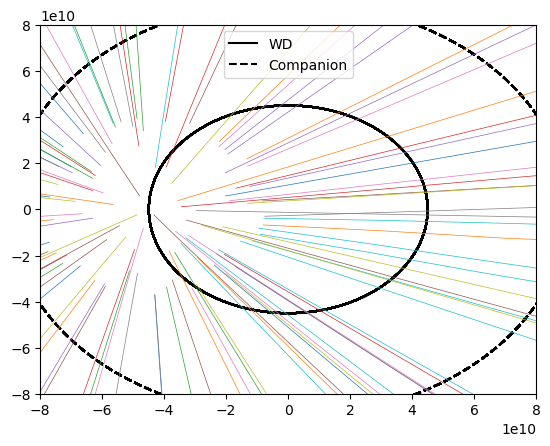

In [7]:
n_part_show = min(100, N_PARTICLES)

# x-y
plt.plot(wd_coord[:, 0], wd_coord[:, 1], ls='-', color='k', label='WD')
plt.plot(companion_coord[:, 0], companion_coord[:, 1], ls='--', color='k', label='Companion')
for j in range(n_part_show):
    plt.plot(particles_coord[j, :, 0], particles_coord[j, :, 1], ls='-', lw=0.5)
plt.legend()
plt.xlim(-8e10, 8e10)
plt.ylim(-8e10, 8e10)

In [8]:
rotation_angle = np.arctan2(wd_coord[:, 0], wd_coord[:, 1]) - np.arctan2(wd_coord[0, 0], wd_coord[0, 1])
rotation_matrix = np.array([
    [np.cos(rotation_angle), -np.sin(rotation_angle), np.zeros_like(rotation_angle)],
    [np.sin(rotation_angle), np.cos(rotation_angle), np.zeros_like(rotation_angle)],
    [np.zeros_like(rotation_angle), np.zeros_like(rotation_angle), np.ones_like(rotation_angle)],
]).T

# Last time moment corresponds to the initial position: no rotation needed
# So we need to go across all time moments in reverse order
ejecta_coord = (particles_coord[:, ::-1, None, :] @ rotation_matrix[None, ...]).reshape(-1, 3)

In [9]:
# ejecta_coord = particles_coord.reshape(-1, 3)

In [10]:
%%time


threshold = 10**3.395

def find_area(phase, plot=True):
    E = np.array([ # rotate around z-axis
        [np.cos(phase), -np.sin(phase), 0],
        [np.sin(phase), np.cos(phase), 0],
        [0, 0, 1],
    ]).T @ np.array([ # rotate around x-axis
        [1, 0, 0],
        [0, np.cos(INCLINATION), -np.sin(INCLINATION)],
        [0, np.sin(INCLINATION), np.cos(INCLINATION)],
    ]).T

    in_observers_frame = ejecta_coord @ E
    t_1 = in_observers_frame[:, 0]
    t_2 = in_observers_frame[:, 1]

    projection, t_1_edges, t_2_edges = np.histogram2d(
        t_1,
        t_2,
        bins=PROJECTION_PIXELS,
        range=[[-PROJECTION_SIZE, PROJECTION_SIZE], [-PROJECTION_SIZE, PROJECTION_SIZE]],
    )

    projection = ndimage.zoom(projection, PROJECTION_ZOOM_FACTOR, order=3)
    t_1_grid = ndimage.zoom(t_1_edges[:-1] + 0.5 * np.diff(t_1_edges)[0], PROJECTION_ZOOM_FACTOR, order=1)
    t_2_grid = ndimage.zoom(t_2_edges[:-1] + 0.5 * np.diff(t_2_edges)[0], PROJECTION_ZOOM_FACTOR, order=1)
    
    area = (projection >= threshold).sum()
    
    if plot:
        plt.figure()
        plt.title(f'phase = {np.rad2deg(phase)/360:.2f}, i = {np.rad2deg(INCLINATION):.0f} deg')
        plt.imshow(
            np.log10(projection),
            origin='lower',
            extent=[-PROJECTION_SIZE_U.to_value(u.R_sun), PROJECTION_SIZE_U.to_value(u.R_sun), -PROJECTION_SIZE_U.to_value(u.R_sun), PROJECTION_SIZE_U.to_value(u.R_sun)]
        )
        plt.colorbar(label='lg(N)')
        plt.contour(
            t_1_grid / const.R_sun.to_value(u.cm),
            t_2_grid / const.R_sun.to_value(u.cm),
            np.log10(projection),
            levels=[np.log10(threshold),],
            colors='k',
            linewidths=0.5,
        )
        plt.xlabel('$x, R_\odot$')
        plt.ylabel('$y, R_\odot$')
        plt.savefig(f'column_density_phase_{np.rad2deg(phase):03.0f}.pdf')
        plt.close()
        
    return area

area = np.array([find_area(phase, plot=True) for phase in tqdm(PHASES)])

100%|██████████| 33/33 [14:08<00:00, 25.70s/it]

CPU times: user 2h 49min 19s, sys: 15min 44s, total: 3h 5min 3s
Wall time: 14min 8s


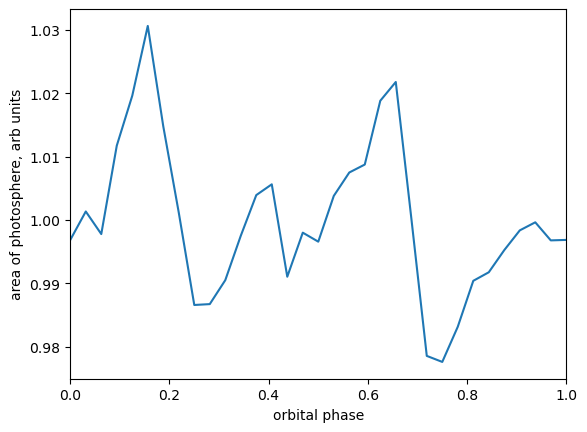

In [11]:
pd.DataFrame(dict(phase=PHASES / (2 * np.pi), area=area)).to_csv('area-phase.csv', index=False)

plt.plot(PHASES / (2 * np.pi), area / area.mean())
plt.xlim([0, 1])
plt.xlabel('orbital phase')
plt.ylabel('area of photosphere, arb units')
plt.savefig('area-phase.pdf')